In [1]:
import numpy as np
import time
import math

In [2]:
class Config: 
    def __init__(self,atoms,pH,pOH,proton_count,conjugate_base_count,timestep,totalEnergy,pressure,temperature):
        self.atoms=atoms
        self.pH=pH
        self.pOH=pOH
        self.proton_count=proton_count
        self.conjugate_base_count=conjugate_base_count
        self.timestep=timestep
        self.totalEnergy=totalEnergy
        self.pressure=pressure
        self.temperature=temperature

In [41]:
class Atom:
    def __init__(self,x,y,z,element,charge,notused,fx,fy,fz,hydrogens,oxygen):
        self.x=float(x)
        self.y=float(y)
        self.z=float(z)
        self.element=str(element)
        self.charge=float(charge)
        self.notused=int(float(notused))
        self.fx=float(fx)
        self.fy=float(fy)
        self.fz=float(fz)
        self.hydrogens=hydrogens
        self.oxygen=oxygen
    
    @classmethod
    def from_lammps(cls, element, x, y, z,notused):
        obj = object.__new__(cls)
        obj.x = float(x)
        obj.y = float(y)
        obj.z = float(z)
        obj.element = str(element)
        obj.notused = notused
        obj.hydrogens=[]
        obj.oxygen=None
        return obj

    
    def scan_vicinity(self,config,cutoff,boxl):
        pivot=np.array([self.x,self.y,self.z])
        config=np.array(config)
        for ind,i in enumerate(config):
            #print(str(ind)+" element= "+i.element,type(i.notused))
            if(i.element=="O"):
                i_vector=np.array([i.x,i.y,i.z])
                #print("O at"+str(ind))
                direction=pivot-i_vector
                direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
                direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
                direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
                dist=np.linalg.norm(direction)
                if(dist<cutoff):
                    #can set notused = 1 here. Need to ponder
                    
                    return False
        return True
    
    def calc_dist(self,pivot,i_vector,boxl):
        direction=pivot-i_vector
        direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
        direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
        direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
        dist=np.linalg.norm(direction)
        return dist
    
    #     def calc_dist(self,i_vector,boxl):
    #         direction=np.array([self.x,self.y,self.z])-i_vector
    #         direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
    #         direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
    #         direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
    #         dist=np.linalg.norm(direction)
    #         return dist
    
    def scan_H_OH(self,config,cutoff,boxl):
        pivot=np.array([self.x,self.y,self.z]) 
        config=np.array(config)
        for ind,i in enumerate(config):
            
            #print("==========================")
            #print(i.element,i.oxygen,i.hydrogens)
            if(i.element=="H"):
                i_vector=np.array([i.x,i.y,i.z])
                dist=self.calc_dist(pivot,i_vector,boxl)
                if(dist<cutoff):
                    if(len(self.hydrogens)<2 and (not (i,dist) in self.hydrogens)):
                        self.hydrogens.append((i,dist))
                        #print("before sorting: ",i.hydrogens)
                        self.hydrogens.sort(key=lambda tup: tup[1])
                        #print("after sorting: ",i.hydrogens)
                        i.oxygen=self
                        #print(i.element,i.oxygen,i.hydrogens)
                        #time.sleep(2)
                    elif(dist<self.hydrogens[-1][1] and (not (i,dist) in self.hydrogens)):
                        print("dist = %s and farthest hydrogen %s" %(dist, self.hydrogens[-1][1]))
                        self.hydrogens[-1][0].oxygen=None
                        self.hydrogens.pop()
                        self.hydrogens.append((i,dist))
                        #print("before sorting: ",i.hydrogens)
                        self.hydrogens.sort(key=lambda tup: tup[1])
                        #print("after sorting: ",i.hydrogens)
                        i.oxygen=self
                        #print(i.element,i.oxygen,i.hydrogens)
                        #time.sleep(2)
                    else:
                        #print("RAN INTO ERROR:",i,i.hydrogens)
                        pass
            
                        
                        
        
                

In [42]:
def parse(f_name):
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for i in f.readlines():
            i=str(i)
            #print(i)
            if("begin" in i):
                temp=[]
            elif("end" in i):
                config.append(Config(temp,None,None,None,None))
                break # need to remove for a whole file
            elif(i.startswith("atom")):
                a=i.split()
                temp.append(Atom(a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9]))
    return config                  

In [43]:
def parse_lammps_output(f_name):
    atoms=['O','H']
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("ITEM: TIMESTEP" in i):
                if(ind>0):
                    config.append(Config(temp,None,None,None,None))
                temp=[]
            elif(any(i.startswith(a) for a in atoms)):
                a=i.split()
                #print(a)
                temp.append(Atom.from_lammps(a[0],a[1],a[2],a[3],0))
    return config


In [44]:
def check_if_number(s):
    try:
        if(float(s).is_integer()):
            return True
        else:
            False
    except:
        return False

In [45]:
def parse_xyz_output(f_name,auto_timestep):
    if(auto_timestep):
        print("Using auto timestep assignment in order")
    atoms=['H','O']
    config=[]
    element='X'
    timestep=-1
    flag=False
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("Atoms. Timestep:" in i ) or ("Lattice" in i):
                if(flag):
                    config.append(Config(temp,None,None,None,None,timestep,None,None,None))
                    a=i.split(":")
                    if(not auto_timestep):
                        timestep=a[-1].strip()
                    else:
                        timestep+=1
                else:
                    if(not auto_timestep):
                        a=i.split(":")
                        timestep=a[-1].strip()
                    else:
                        timestep+=1
                        
                temp=[]
            elif((any(i.startswith(atom) for atom in atoms)) and (not check_if_number(i))):
                flag=True
                a=i.split()
                # Since elements are not marked with number here, need to assign element manually, hence passing the element
                if(a[0]==atoms[0]):
                    element="H"
                elif(a[0]==atoms[1]):
                    element="O"
                temp.append(Atom.from_lammps(element,a[1],a[2],a[3],0))
        config.append(Config(temp,None,None,None,None,timestep,None,None,None))
    return config

In [46]:
def parse_biased_xyz(f_name):
    atoms=['O','H']
    config=[]
    element='X'
    timestep=-1
    flag=False
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("Atoms. Timestep:" in i ):
                
                if(flag):
                    config.append(Config(temp,None,None,None,None,timestep,None,None,None))
                    a=i.split(":")
                    timestep=a[-1].strip()
                else:
                    a=i.split(":")
                    timestep=a[-1].strip()
                temp=[]
            elif((any(i.startswith(atom) for atom in atoms)) and (not check_if_number(i))):
                flag=True
                a=i.split()
                # Since elements are not marked with number here, need to assign element manually, hence passing the element
                if(a[0]==atoms[0]):
                    element="H"
                elif(a[0]==atoms[1]):
                    element="O"
                temp.append(Atom.from_lammps(element,a[1],a[2],a[3],0))
        config.append(Config(temp,None,None,None,None,timestep,None,None,None))
    return config

In [47]:
def pH(proton_count,boxl,Na):
    print("Proton Count = "+str(proton_count))
    n=proton_count/Na
    vol=1000*(boxl**3)
    #Molarity=n/vol
    #print("molarity=",Molarity)
    return -1*(np.log10(n)-np.log10(vol))

In [48]:
from sys import argv as a
import numpy as np
import matplotlib.pyplot as plt
import json

# Parse File

In [49]:
#config=parse("../training-set/input.data")
configs=parse_xyz_output("./trajectory_wrapped.xyz",True)
# configs=parse_biased_xyz("./out_biased6.xyz")
#config=parse_lammps_output("./out6.lammpstrj")


Using auto timestep assignment in order


In [113]:
config=configs[::100]
print("config size",np.shape(config))
print(config[0])
protons=[]

config size (16,)


# Set Constants

In [114]:
cutoff=2.17#1.15#11.3383# 2.173185 # needs to be atomic units since the coordinates are in atomic units
boxl_atomic=23.46511#46.937#23.465110
Na=6.0221409e+23
atomic_to_angstron=0.5291772083
boxl_angstron=boxl_atomic*atomic_to_angstron
boxl_meters=boxl_angstron**-8

# Proton Count

In [115]:
for ind,j in enumerate(config):
    #print("number of atoms = ",len(j))
    print(j.timestep)
    proton_count=0
    oh_count=0
    h2o_count=0
    for ind2,i in enumerate(j.atoms):
        #print(i.__dict__)
        if(i.element=="O"):
            #print("H at"+str(ind2))
            #print(config)
            i.scan_H_OH(j.atoms,cutoff,boxl_atomic)
    for ind2,i in enumerate(j.atoms):
        if(i.element=="H"): 
            if(i.oxygen==None):
                proton_count+=1
        elif(i.element=="O" and len(i.hydrogens)==1):
            oh_count+=1
        elif(i.element=="O" and len(i.hydrogens)==2):
            h2o_count+=1
        #else:
        #    print("something happened here",i,json.dumps(i.__dict__))
    j.proton_count=proton_count
    j.conjugate_base_count=oh_count
    total=proton_count+2*oh_count+3*h2o_count
    protons.append((proton_count,oh_count,h2o_count,total))
    #print(protons[-1])

0
100
dist = 1.882269313886829 and farthest hydrogen 1.980724965662825
200
dist = 1.232617288739696 and farthest hydrogen 1.9710979685606695
300
dist = 1.6039542342598179 and farthest hydrogen 2.072150606399063
dist = 1.7021898017027948 and farthest hydrogen 1.9470019826389504
400
dist = 1.643250517754368 and farthest hydrogen 1.9064018795888762
dist = 1.6899269371780559 and farthest hydrogen 1.829410303895766
500
600
700
dist = 2.0479610299270816 and farthest hydrogen 2.161384498278822
dist = 1.9602108515249068 and farthest hydrogen 2.09092518271219
800
dist = 1.7245035280914904 and farthest hydrogen 1.9251846852964507
dist = 1.7845141848973902 and farthest hydrogen 2.1339567311686514
dist = 1.6895756922967367 and farthest hydrogen 2.067957253523388
900
1000
dist = 1.5069703510686607 and farthest hydrogen 1.9449529016405513
dist = 1.2632995067283137 and farthest hydrogen 1.7606539120735798
dist = 1.5047516115625192 and farthest hydrogen 1.8523579000830266
dist = 0.8768841773575357 and

In [171]:
def getlen(o):
    if(o==None):
        return 0
    else:
        return 1
print(config[10].proton_count,config[10].conjugate_base_count,protons[10])
for i in config[10].atoms:
    if(i.element=="H"):
        print(i.element,"oxygen=",str(getlen(i.oxygen)),"hydrogens=",len(i.hydrogens))

22 3 (22, 3, 60, 208)
H oxygen= 0 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H o

# Parse slurm output

In [117]:
def split_slurm_line(line):
    a=line.split()
    return len(a),a    

In [118]:

with open("outbiased6_slurm.out",'r') as f:
    temp=[]
    flag=True
    for line in f:
        if((flag)and (not "Step Temp E_pair E_mol TotEng Press" in line)):
              pass
        else:
            flag=False
            alen,a=split_slurm_line(line)
            if(alen==6 and not("Step Temp E_pair E_mol TotEng Press" in line)):
                config_selection= next((x for x in config if x.timestep == a[0]), None)
                if(config_selection!=None):
                    #print(a)
                    config_selection.temperature=float(a[1])
                    config_selection.totalEnergy=float(a[4])
                    config_selection.pressure=float(a[5])
        #f.next
        

FileNotFoundError: [Errno 2] No such file or directory: 'outbiased6_slurm.out'

In [ ]:
for i in config:
    print(i.timestep,len(i.atoms),i.pressure,i.temperature)

# FEP (might be wrong since we're doing it on microstates)
Doing all values in metal units i.e. eV, Angstron. 
- feps is a list of lists as [timestep0,timestep1,Freeenergy(eV)]

In [119]:
kb=math.exp(8.6173e-5)
print("kb=",kb)
Tc=300
feps=[]

kb= 1.0000861767129996


In [120]:
for ind in range(len(config)-1):
    e0=config[ind].totalEnergy
    e1=config[ind+1].totalEnergy
    exp=math.exp(-1*(e1-e0)/(kb*Tc))
    F=-1*kb*Tc*np.log(exp)
    feps.append([config[ind].timestep,config[ind+1].timestep,F])

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [121]:
print(feps)

[]


ValueError: min() arg is an empty sequence

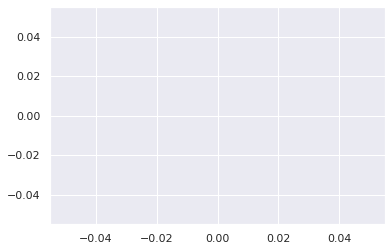

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
x_val=[float(x[0])for x in feps]
y_val=[float(x[-1]) for x in feps]
plt.plot(x_val[:500],y_val[:500])
plt.xticks(np.arange(min(x_val), max(x_val)+1, 1.0))
plt.show()


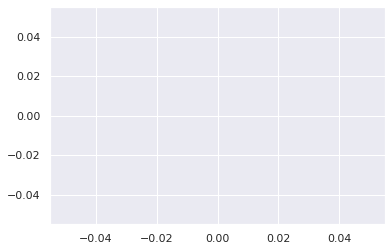

In [123]:
import matplotlib.pyplot as plt

plt.bar(x_val[500:5000],y_val[500:5000])
plt.show()


# pH calculation

In [124]:
ph=[]
for i,prot in enumerate(protons):
    ph_temp=pH(prot[0],boxl_atomic*(10**-10),Na)
    poh_temp=pH(prot[1],boxl_atomic*(10**-10),Na)
    #print(i,". pH = ",ph_temp)
    ph.append((ph_temp,poh_temp))
    config[i].pH=ph_temp
    config[i].pOH=poh_temp



#    print("pH of config-"+str(ind)+" = "+str(pH(proton_count,boxl_meters,Na)))

Proton Count = 2
Proton Count = 2
Proton Count = 7
Proton Count = 7
Proton Count = 1
Proton Count = 1
Proton Count = 4
Proton Count = 3
Proton Count = 7
Proton Count = 5
Proton Count = 6
Proton Count = 4
Proton Count = 10
Proton Count = 10
Proton Count = 6
Proton Count = 4
Proton Count = 8
Proton Count = 5
Proton Count = 26
Proton Count = 20
Proton Count = 22
Proton Count = 3
Proton Count = 2
Proton Count = 2
Proton Count = 9
Proton Count = 5
Proton Count = 0
Proton Count = 0
Proton Count = 0
Proton Count = 0
Proton Count = 3
Proton Count = 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [125]:
# if __name__ == "__main__":
#     protons,ph=main()
#     protons=np.array(protons)
#     ph=np.array(ph)
#     #print("protons by config= ",protons)
    
 

In [126]:
count_91=0
count_90=0
count_shorts=0
for i in protons:
    if(i[3]==191 and i[0]-i[1]==2):
        count_91+=1
    elif(i[3]==190 and i[0]-i[1]==4):
        count_90+=1
    elif(i[3]!=192):
        count_shorts+=1
        
print(count_91,count_90,count_shorts)

1 0 8


In [127]:
print("pH,pOH by config= ",ph)

pH,pOH by config=  [(0.5899887001485773, 0.5899887001485773), (0.045920655798301624, 0.045920655798301624), (0.8910186958125585, 0.8910186958125585), (0.28895870448459604, 0.41389744109289595), (0.045920655798301624, 0.1920486914765398), (0.11286744542891469, 0.28895870448459604), (-0.10898130418744145, -0.10898130418744145), (0.11286744542891469, 0.28895870448459604), (-0.012071291179385213, 0.1920486914765398), (-0.5239546521582596, -0.4100112998514227), (-0.45140398500964807, 0.41389744109289595), (0.5899887001485773, 0.5899887001485773), (-0.06322381362676666, 0.1920486914765398), (inf, inf), (inf, inf), (0.41389744109289595, 0.5899887001485773)]


In [128]:
print("pKw by config= ")
for i in ph:
    print(i[0]+i[1])

pKw by config= 
1.1799774002971546
0.09184131159660325
1.782037391625117
0.702856145577492
0.23796934727484143
0.40182614991351073
-0.2179626083748829
0.40182614991351073
0.1799774002971546
-0.9339659520096824
-0.03750654391675212
1.1799774002971546
0.12882487784977315
inf
inf
1.0038861412414732


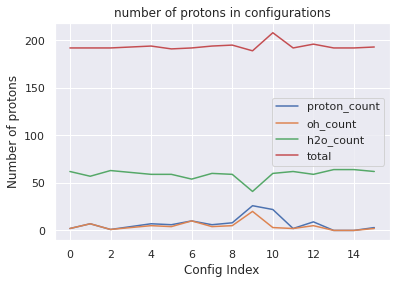

In [129]:
plt.title("number of protons in configurations")
plt.xlabel('Config Index')
plt.ylabel('Number of protons')
plt.plot(np.arange(len(protons)),protons)
plt.legend(['proton_count','oh_count','h2o_count','total'])
plt.show()

(array([2., 1., 2., 1., 1., 0., 2., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <BarContainer object of 26 artists>)

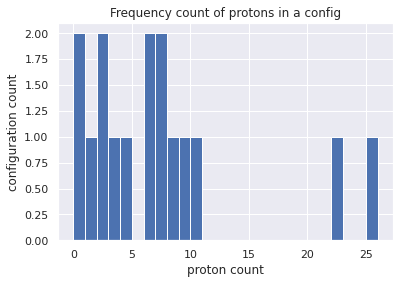

In [130]:
plt.title("Frequency count of protons in a config")
plt.xlabel("proton count")
plt.ylabel("configuration count")
pros=np.array([i[0] for i in protons])
plt.hist(pros, bins=np.arange(pros.min(), pros.max()+1))


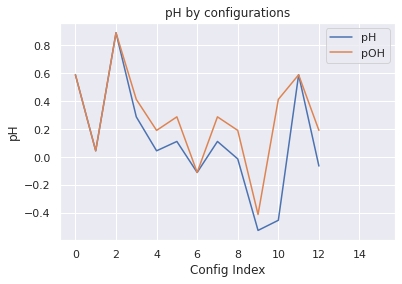

In [131]:
plt.title("pH by configurations")
plt.xlabel('Config Index')
plt.ylabel('pH')
plt.plot(np.arange(len(ph)),ph)
plt.legend(['pH','pOH'])
plt.show()

In [132]:
# disassociation const 

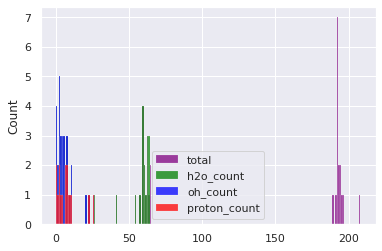

In [140]:
data = protons
sns.set()
for i, color in enumerate(['red', 'blue', 'green', 'purple'][::-1]):
    sns.histplot([di for d in data for di in d[:4-i]], binwidth=1, color=color, stat="count")
plt.legend(['proton_count','oh_count','h2o_count','total'][::-1])
plt.show()

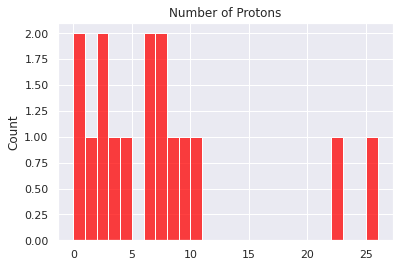

In [141]:
sns.histplot([d[0] for d in data],color='red',binwidth=1)
plt.title("Number of Protons")
plt.show()

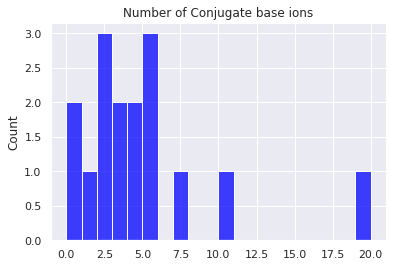

In [142]:
sns.histplot([d[1] for d in data],color='blue',binwidth=1)
plt.title("Number of Conjugate base ions")
plt.show()

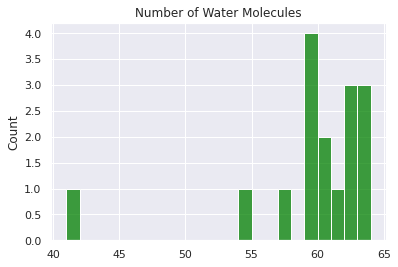

In [143]:
sns.histplot([d[2] for d in data],color='green',binwidth=1)
plt.title("Number of Water Molecules")
plt.show()

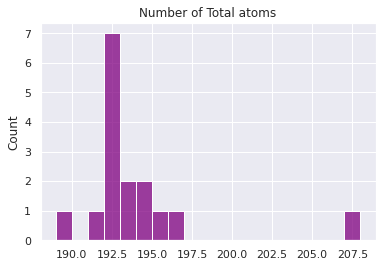

In [145]:
sns.histplot([d[3] for d in data],color='purple',binwidth=1)
plt.title("Number of Total atoms")
plt.show()